# Analyse der Gesamttabelle

In [1]:
# Import der notwendigen Bibliotheken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Konfiguration
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

stores = pd.read_csv("data/stores.csv")
products = pd.read_csv("data/products.csv")
transactions = pd.read_parquet("data/transactions_train_1.parquet")
transaction_lines = pd.read_parquet("data/transaction_lines_train_1.parquet")

## Join

In [ ]:
# ID-Spallten für Join umbenennen
stores.rename(columns={"id": "store_id"}, inplace=True)
products.rename(columns={"id": "product_id"}, inplace=True)
transactions.rename(columns={"id": "transaction_id"}, inplace=True)

# Transaction-Tabelle mit Store-Tabelle  joinen
joined_transactions = transactions.merge(stores, on="store_id", how="left")

# Transaction_lines-Tabelle mit Product-Tabelle joinen
joined_transactionlines = transaction_lines.merge(products, on="product_id", how="left")

## Tabelle joined_transactions

In [39]:
# Datentypen ansehen
joined_transactions.dtypes

transaction_id               object
store_id                     object
cash_desk                     int64
transaction_start    datetime64[us]
transaction_end      datetime64[us]
total_amount                float64
n_lines                       int64
payment_medium               object
customer_feedback           float64
damage                      float64
label                        object
location                     object
state                        object
urbanization                 object
actual_n_lines              float64
dtype: object

In [16]:
joined_transactions.shape

(1558245, 14)

In [40]:
# Tabelle ansehen
joined_transactions.head(3)

,transaction_id,store_id,cash_desk,transaction_start,transaction_end,total_amount,n_lines,payment_medium,customer_feedback,damage,label,location,state,urbanization,actual_n_lines
0,5bedf771-f016-41a7-ab89-f40e7f6be955,b0973ffa-ce15-41e0-9de7-1390598e24f2,0,2022-02-02 08:00:12,2022-02-02 08:01:02.825563,52.26,6,CREDIT_CARD,NaN,NaN,UNKNOWN,Berlin,Berlin,RURAL,6.0
1,21ff1406-dbc4-41a7-8429-836cbf96d853,b0973ffa-ce15-41e0-9de7-1390598e24f2,1,2022-02-02 08:05:06,2022-02-02 08:05:30.565876,1.47,1,CREDIT_CARD,NaN,NaN,UNKNOWN,Berlin,Berlin,RURAL,1.0
2,b642f9b6-43b5-413d-ad08-b4bf4b664b52,b0973ffa-ce15-41e0-9de7-1390598e24f2,2,2022-02-02 08:07:12,2022-02-02 08:11:29.434607,363.87,37,CREDIT_CARD,NaN,0.0,NORMAL,Berlin,Berlin,RURAL,38.0


Löschen der Spalten 'opening_date' und 'sco_introduction' aufgrund Irrelevanz

In [12]:
joined_transactions.drop(columns=['opening_date', 'sco_introduction'], inplace=True)

Spalten mit fehlenden Werten

In [15]:
missing_values = joined_transactions.isnull().sum()
print(missing_values)

transaction_id             0
store_id                   0
cash_desk                  0
transaction_start          0
transaction_end            0
total_amount               0
n_lines                    0
payment_medium             0
customer_feedback    1449915
damage               1402553
label                      0
location                   0
state                      0
urbanization               0
dtype: int64


--> 'customer_Feedback' hat rund 96% und 'damage' rund 93% fehlende Werte. 

'customer_feedback'

In [18]:
# Absolute Häufigkeit (inkl. NaN)
feedback_counts = joined_transactions['customer_feedback'].value_counts(dropna=False)

# Prozentuale Verteilung
feedback_percent = joined_transactions['customer_feedback'].value_counts(normalize=True, dropna=False) * 100

# Kombinieren in DataFrame
feedback_summary = pd.DataFrame({
    'Anzahl': feedback_counts,
    'Prozent': feedback_percent.round(2)
})

print(feedback_summary)

                    Anzahl  Prozent
customer_feedback                  
NaN                1449915    93.05
10.0                 83637     5.37
9.0                   5431     0.35
8.0                   4473     0.29
7.0                   3714     0.24
6.0                   2816     0.18
1.0                   2516     0.16
5.0                   2126     0.14
4.0                   1620     0.10
3.0                   1086     0.07
2.0                    911     0.06


In [19]:
# Korrelation zum Label prüfen
pd.crosstab(joined_transactions['customer_feedback'], joined_transactions['label'], normalize='index') * 100

label,FRAUD,NORMAL,UNKNOWN
customer_feedback,,,
1.0,0.198728,9.379968,90.421304
2.0,0.000000,9.110867,90.889133
3.0,0.276243,10.773481,88.950276
4.0,0.000000,8.888889,91.111111
5.0,0.235183,9.689558,90.075259
6.0,0.106534,9.943182,89.950284
7.0,0.107701,9.962305,89.929995
8.0,0.089425,10.283926,89.626649
9.0,0.110477,9.206408,90.683115


In [20]:
pd.crosstab(joined_transactions['customer_feedback'], joined_transactions['label'])


label,FRAUD,NORMAL,UNKNOWN
customer_feedback,,,
1.0,5,236,2275
2.0,0,83,828
3.0,3,117,966
4.0,0,144,1476
5.0,5,206,1915
6.0,3,280,2533
7.0,4,370,3340
8.0,4,460,4009
9.0,6,500,4925


Doppelte Zeilen und IDs

In [22]:
# Prüft, ob vollständige Duplikate (identische Zeilen) existieren
duplicate_rows = joined_transactions[joined_transactions.duplicated()]
print(f"Anzahl vollständig doppelter Zeilen: {len(duplicate_rows)}")


Anzahl vollständig doppelter Zeilen: 0


In [23]:
# Prüft, ob die transaction_id mehrfach vorkommt
duplicate_ids = joined_transactions['transaction_id'].duplicated().sum()
print(f"Anzahl mehrfach vorkommender transaction_ids: {duplicate_ids}")

Anzahl mehrfach vorkommender transaction_ids: 0


### Explorative Datenanalyse

In [41]:
# Entferne Zeilen mit label == "UNKNOWN"
joined_transactions = joined_transactions[joined_transactions['label'].isin(['NORMAL', 'FRAUD'])].copy()

In [42]:
# --- Basisübersicht ---
print("\nDatenübersicht:")
print(joined_transactions.info())
print("\nStatistische Beschreibung:")
print(joined_transactions.describe(include='all'))


Datenübersicht:
<class 'pandas.core.frame.DataFrame'>
Index: 155692 entries, 2 to 1558199
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   transaction_id     155692 non-null  object        
 1   store_id           155692 non-null  object        
 2   cash_desk          155692 non-null  int64         
 3   transaction_start  155692 non-null  datetime64[us]
 4   transaction_end    155692 non-null  datetime64[us]
 5   total_amount       155692 non-null  float64       
 6   n_lines            155692 non-null  int64         
 7   payment_medium     155692 non-null  object        
 8   customer_feedback  10641 non-null   float64       
 9   damage             155692 non-null  float64       
 10  label              155692 non-null  object        
 11  location           155692 non-null  object        
 12  state              155692 non-null  object        
 13  urbanization       155692 non-n


Verteilung der Zielvariable 'label':
label
NORMAL    0.967885
FRAUD     0.032115
Name: proportion, dtype: float64


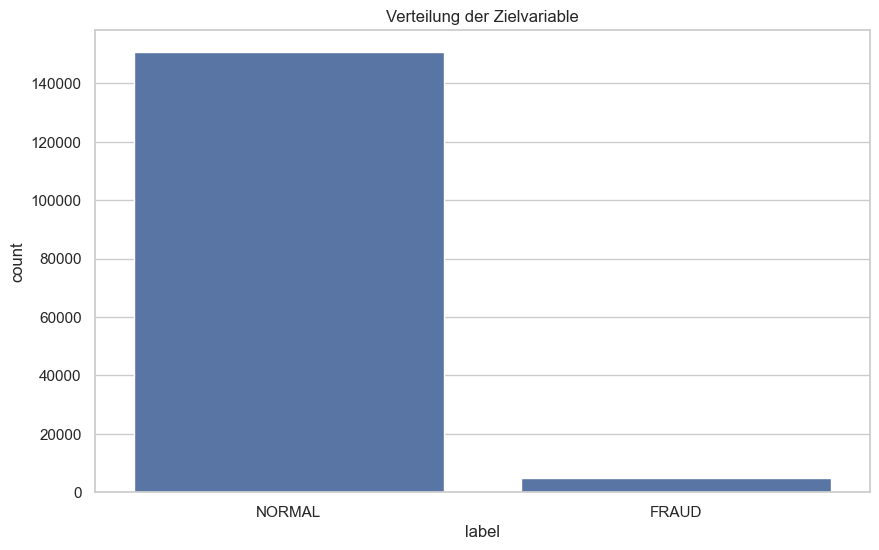

In [43]:
# --- Verteilung der Zielvariable ---
print("\nVerteilung der Zielvariable 'label':")
print(joined_transactions['label'].value_counts(normalize=True))
sns.countplot(data=joined_transactions, x='label')
plt.title('Verteilung der Zielvariable')
plt.show()

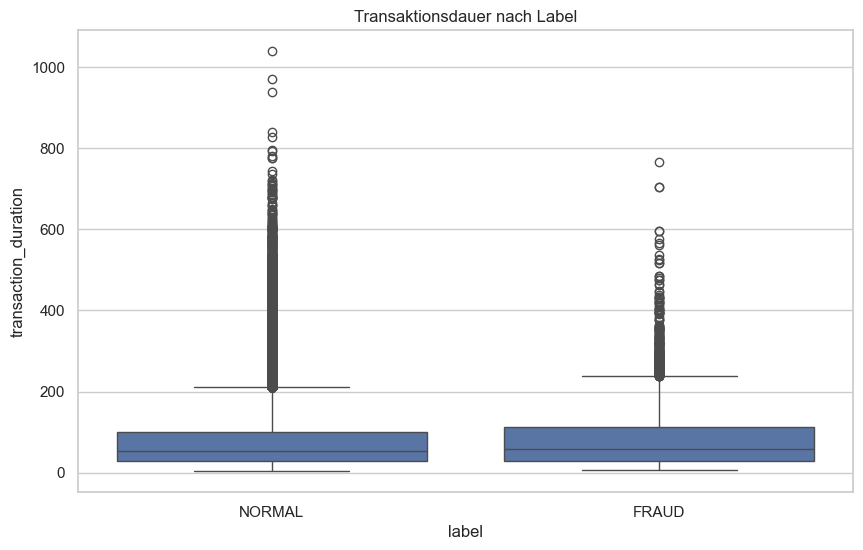

In [44]:
# --- Transaktionsdauer ---
joined_transactions['transaction_duration'] = (joined_transactions['transaction_end'] - joined_transactions['transaction_start']).dt.total_seconds()
sns.boxplot(data=joined_transactions, x='label', y='transaction_duration')
plt.title('Transaktionsdauer nach Label')
plt.show()

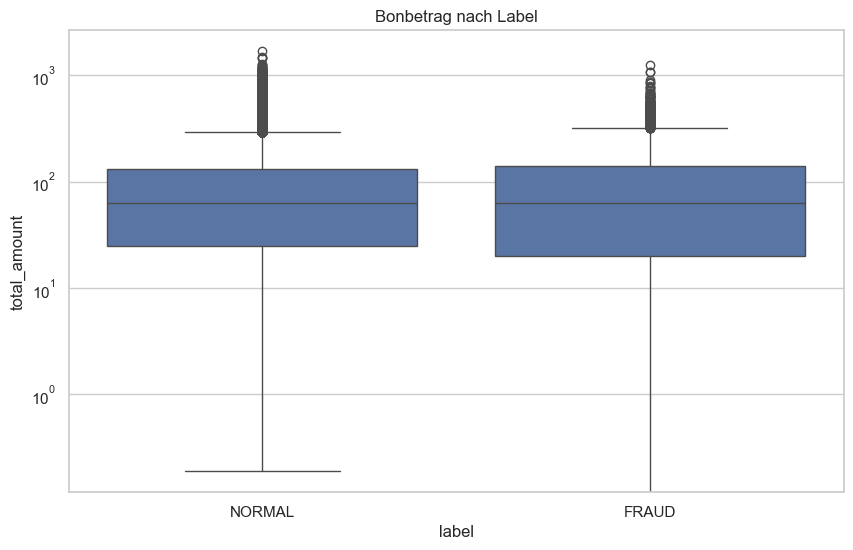

In [45]:
# --- Total Amount ---
sns.boxplot(data=joined_transactions, x='label', y='total_amount')
plt.title('Bonbetrag nach Label')
plt.yscale('log')
plt.show()

In [48]:
from scipy.stats import mannwhitneyu, chi2_contingency
from sklearn.preprocessing import LabelEncoder

In [49]:
# Transaktionsdauer als Feature anlegen
joined_transactions['transaction_duration'] = (joined_transactions['transaction_end'] - joined_transactions['transaction_start']).dt.total_seconds()

In [50]:
# --- Zielvariable in binäres Format bringen ---
le = LabelEncoder()
joined_transactions['label_bin'] = le.fit_transform(joined_transactions['label'])  # FRAUD = 1, NORMAL = 0

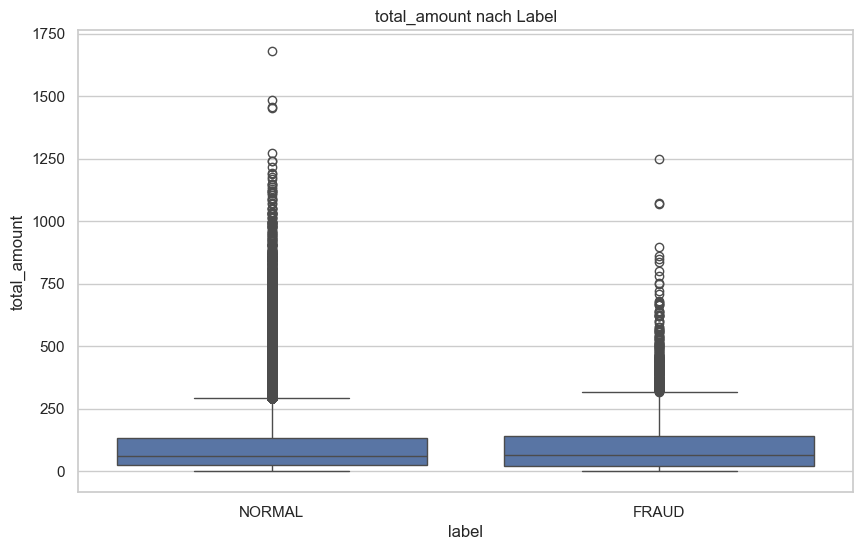

total_amount: Mann-Whitney-U-Test p-Wert = 0.0412


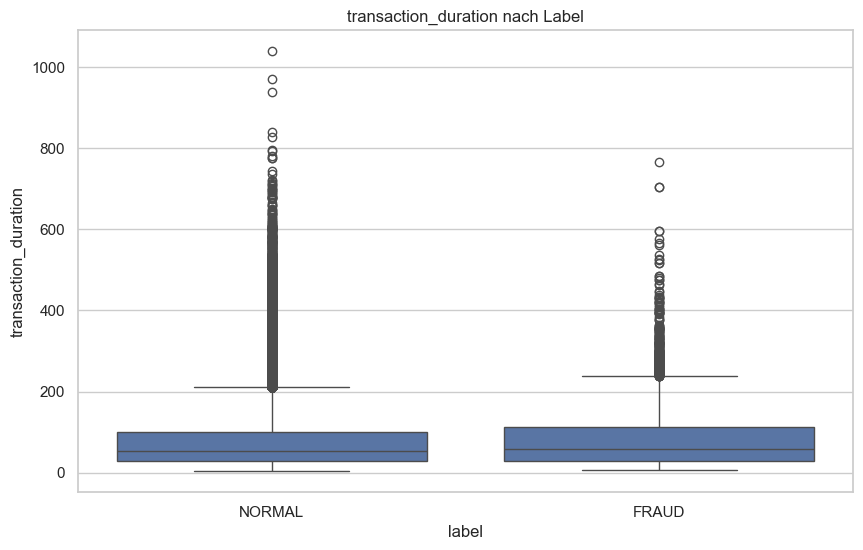

transaction_duration: Mann-Whitney-U-Test p-Wert = 0.0000


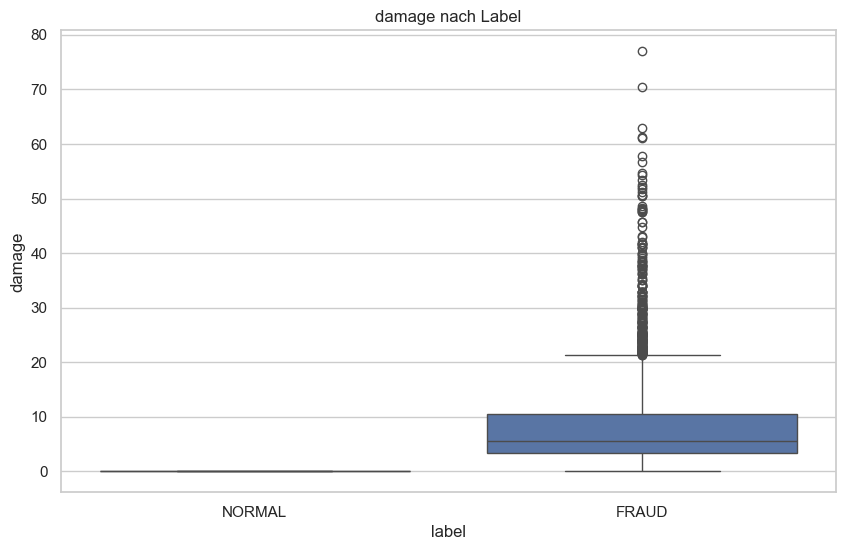

damage: Mann-Whitney-U-Test p-Wert = 0.0000


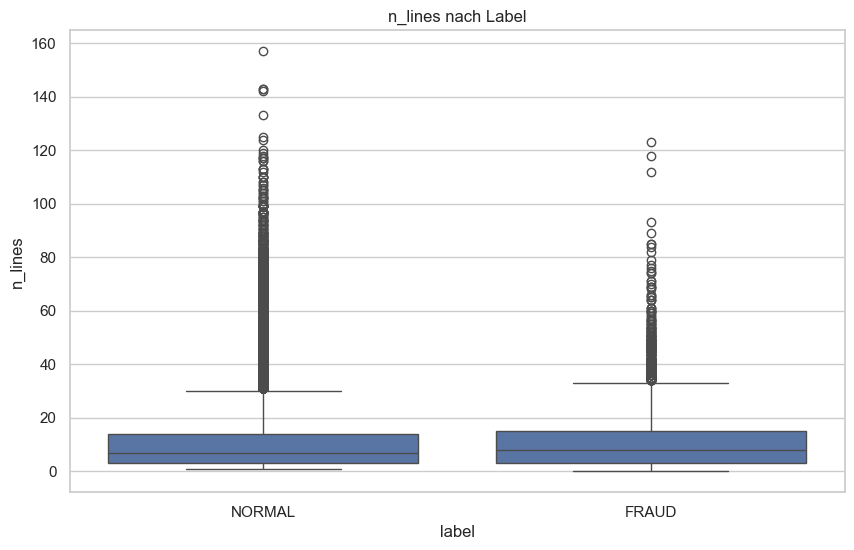

n_lines: Mann-Whitney-U-Test p-Wert = 0.0002


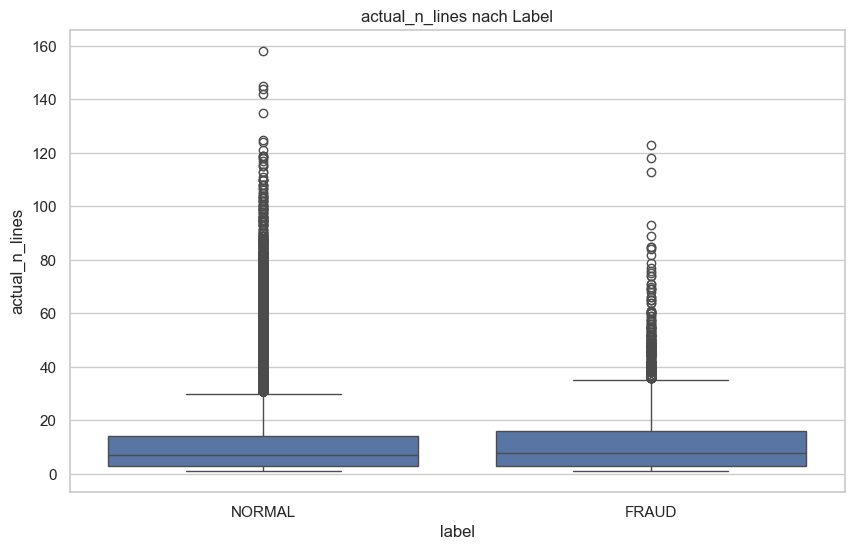

actual_n_lines: Mann-Whitney-U-Test p-Wert = 0.0000


In [52]:
# --- Analyse numerischer Features ---
numerical_features = ['total_amount', 'transaction_duration', 'damage', 'n_lines', 'actual_n_lines']

for feature in numerical_features:
    sns.boxplot(data=joined_transactions, x='label', y=feature)
    plt.title(f'{feature} nach Label')
    plt.show()

    fraud_values = joined_transactions[joined_transactions['label'] == 'FRAUD'][feature].dropna()
    normal_values = joined_transactions[joined_transactions['label'] == 'NORMAL'][feature].dropna()

    stat, p = mannwhitneyu(fraud_values, normal_values, alternative='two-sided')
    print(f"{feature}: Mann-Whitney-U-Test p-Wert = {p:.4f}")


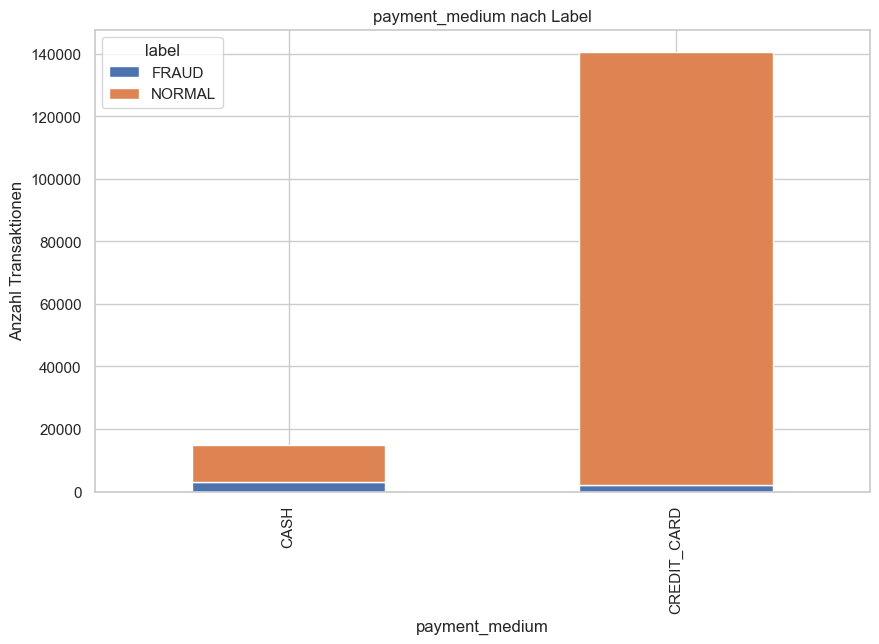

payment_medium: Chi²-Test p-Wert = 0.0000


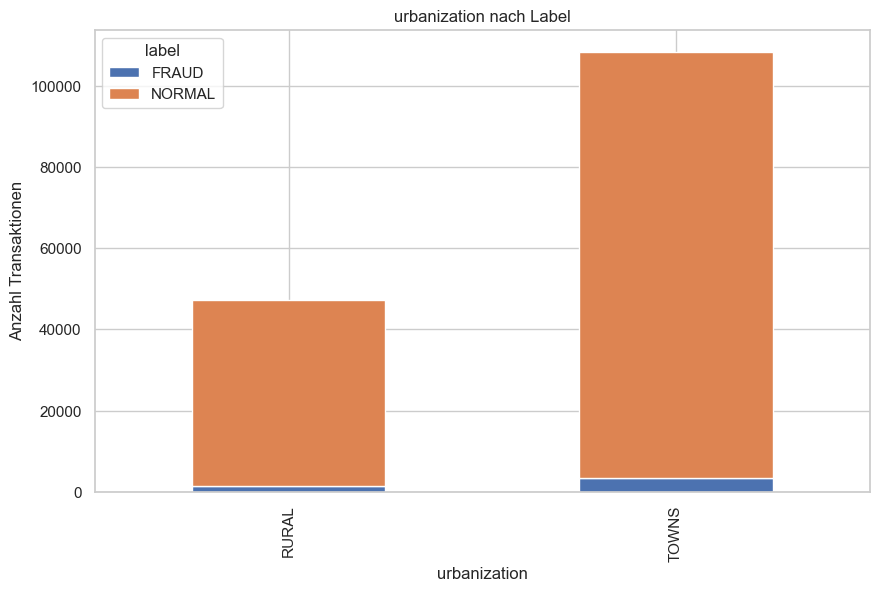

urbanization: Chi²-Test p-Wert = 0.7464


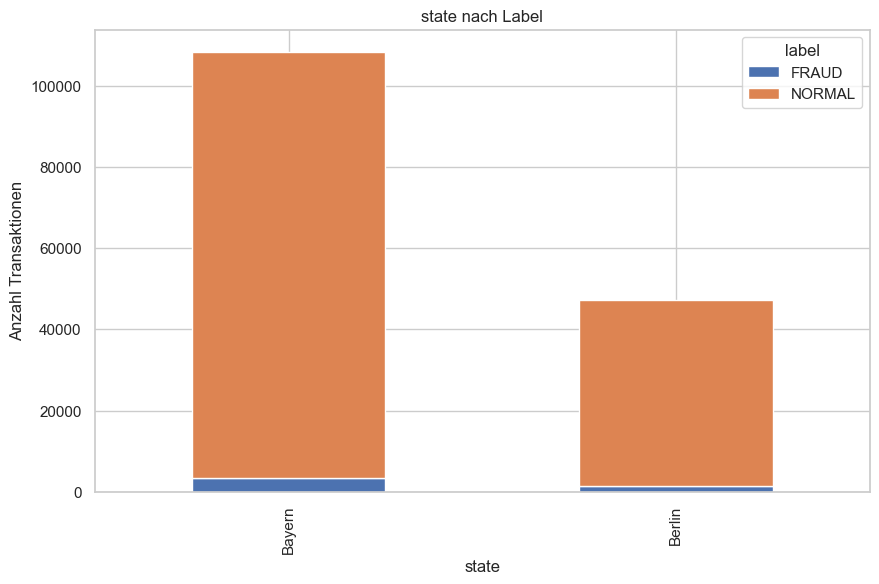

state: Chi²-Test p-Wert = 0.7464


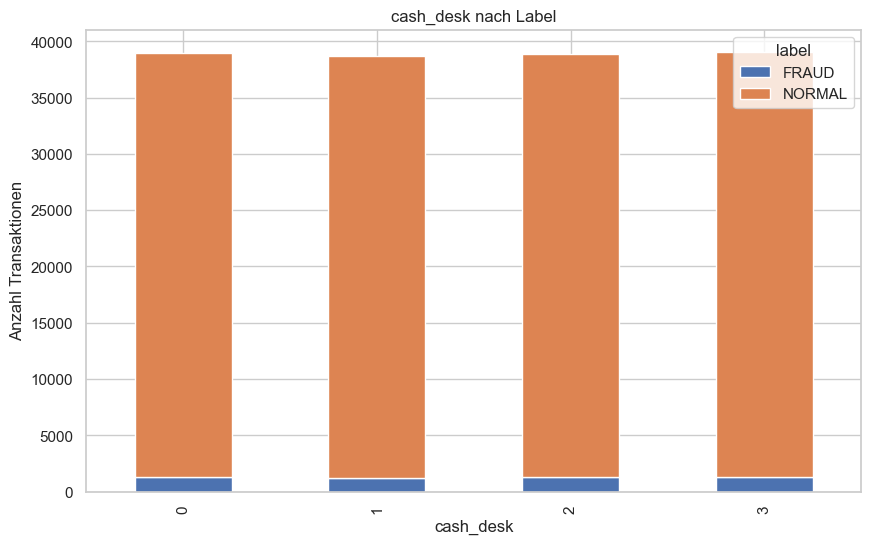

cash_desk: Chi²-Test p-Wert = 0.6781


In [53]:
# --- Analyse kategorischer Features ---
categorical_features = ['payment_medium', 'urbanization', 'state', 'cash_desk']

for feature in categorical_features:
    ctab = pd.crosstab(joined_transactions[feature], joined_transactions['label'])
    ctab.plot(kind='bar', stacked=True)
    plt.title(f'{feature} nach Label')
    plt.ylabel('Anzahl Transaktionen')
    plt.show()

    chi2, p, dof, expected = chi2_contingency(ctab)
    print(f"{feature}: Chi²-Test p-Wert = {p:.4f}")


In [54]:
print(joined_transactions.groupby('label')['total_amount'].median())


label
FRAUD     63.53
NORMAL    62.64
Name: total_amount, dtype: float64


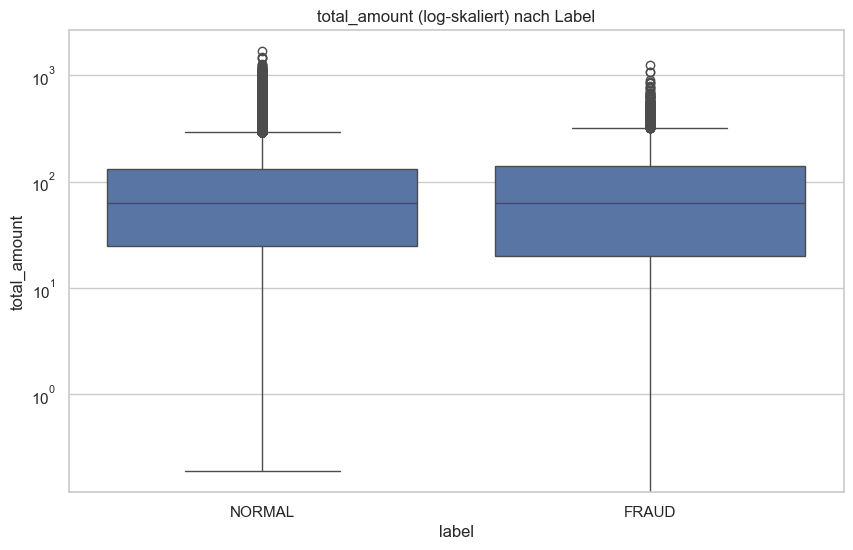

In [55]:
# Visualisierung mit log-Skalierung
sns.boxplot(data=joined_transactions, x='label', y='total_amount')
plt.yscale('log')
plt.title('total_amount (log-skaliert) nach Label')
plt.show()


--> In der explorativen Analyse zeigte total_amount einen signifikanten Unterschied zwischen betrügerischen und normalen Transaktionen (p = 0.0412, Mann-Whitney-U). Dies spricht für eine potenzielle Relevanz des Betrags als Merkmal zur Klassifikation.

Zusammenhang Feesbach vs. Label

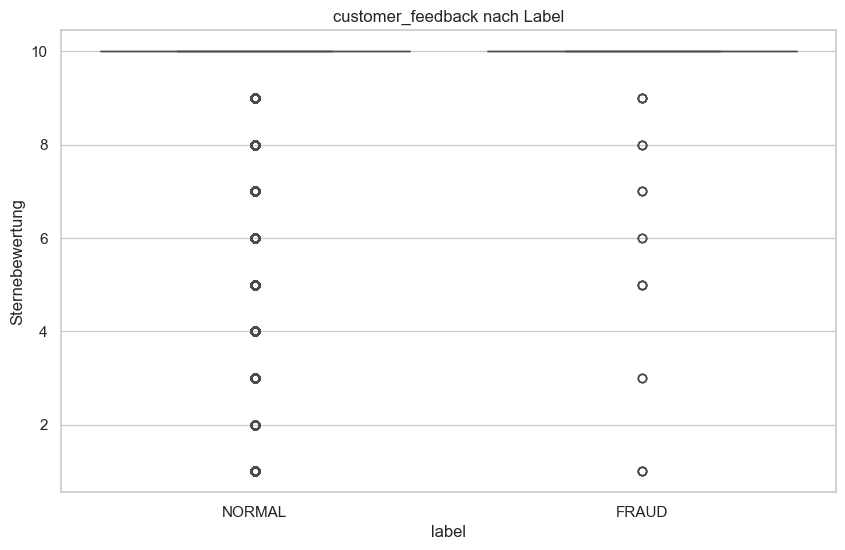

customer_feedback: Mann-Whitney-U-Test p-Wert = 0.0000


In [56]:
# Nur Transaktionen mit Feedback analysieren
feedback_df = joined_transactions[~joined_transactions['customer_feedback'].isnull()]

# Boxplot: Feedback nach Label
sns.boxplot(data=feedback_df, x='label', y='customer_feedback')
plt.title('customer_feedback nach Label')
plt.ylabel('Sternebewertung')
plt.show()

# Mann-Whitney-U-Test
fraud_fb = feedback_df[feedback_df['label'] == 'FRAUD']['customer_feedback']
normal_fb = feedback_df[feedback_df['label'] == 'NORMAL']['customer_feedback']
stat, p = mannwhitneyu(fraud_fb, normal_fb, alternative='two-sided')
print(f"customer_feedback: Mann-Whitney-U-Test p-Wert = {p:.4f}")


• **Zusammenhang zwischen Gesamtbetrag und Label:** In der explorativen Analyse zeigte total_amount einen signifikanten Unterschied zwischen betrügerischen und normalen Transaktionen (p = 0.0412, Mann-Whitney-U). Dies spricht für eine potenzielle Relevanz des Betrags als Merkmal zur Klassifikation

• **Zusammenhang zur Transaktionsdauer:** Das Merkmal transaction_duration zeigte in der explorativen Analyse eine hochsignifikante Differenz zwischen den Klassen FRAUD und NORMAL (p < 0.0001, Mann-Whitney-U). Dies lässt auf ein potenziell nützliches Prädiktor-Merkmal für spätere Klassifikationsverfahren schließen.
Visuell: Fraud-Transaktionen scheinen im Median leicht kürzer, aber mit teils hohen Ausreißern. Mögliche Erklärung: Betrüger:innen „eilen“ beim Scan-Vorgang – oder pausieren ungewöhnlich lange (z. B. bei Manipulation?).

• **Zusammenhang zur Warenkorbgröße:** Die Variable n_lines (Anzahl gescannter Positionen) weist mit p = 0.0002 einen signifikanten Unterschied zwischen normalen und betrügerischen Transaktionen auf. Dies deutet darauf hin, dass Fraud-Fälle im Mittel (Median) mehr Positionen enthalten.

• **Zusammenhang zum Zahlungsmittel:** Das Merkmal payment_medium zeigte einen hochsignifikanten Zusammenhang mit der Zielvariable (p < 0.0001, Chi²-Test). Insbesondere ist ein überproportionaler Anteil betrügerischer Transaktionen bei Barzahlung zu beobachten. Dieses Merkmal wird daher als potenziell erklärungsrelevant für spätere Modellierungen berücksichtigt.

• **Zusammenhang zur Urbanisierung:** Im Rahmen der explorativen Analyse ergab sich für das Merkmal urbanization kein signifikanter Zusammenhang mit der Zielvariable (p = 0.7464, Chi²-Test). Das Merkmal wird daher als potenziell irrelevant für die Klassifikation betrachtet.

• **Zusammenhang zum Bundesland:** Für das Merkmal state (Bundesland) zeigte sich kein signifikanter Zusammenhang mit der Zielvariable (p = 0.7464, Chi²-Test). Es wird daher als nicht erklärungsrelevant eingestuft und kann in der Merkmalsauswahl ignoriert werden.

• **Zusammenhang zur Kasse:** Das Merkmal cash_desk zeigte in der Chi²-Analyse keinen signifikanten Zusammenhang mit der Zielvariable (p = 0.6781). Es liefert damit keinen Mehrwert für die spätere Modellbildung.

• **Zusammenhang zum Customer Feedback:** Die Variable customer_feedback, welche nur bei Self-Checkout-Transaktionen verfügbar ist, zeigt einen hochsignifikanten Zusammenhang mit dem Transaktionslabel (p < 0.0001, Mann-Whitney-U-Test). Die Daten legen nahe, dass betrügerische Transaktionen im Durchschnitt deutlich schlechter bewertet werden, was auf ein erhöhtes subjektives Unbehagen oder Misstrauen der Kundschaft hinweisen könnte.

## Tabelle joined_transactionlines

In [28]:
joined_transactionlines.dtypes

id                                 int64
transaction_id                    object
product_id                        object
timestamp                 datetime64[us]
pieces_or_weight                 float64
sales_price                      float64
was_voided                          bool
camera_product_similar            object
camera_certainty                 float64
category                          object
price                            float64
popularity                       float64
valid_from                        object
valid_to                          object
sold_by_weight                    object
weight                           float64
age_restricted                    object
dtype: object

In [17]:
joined_transactionlines.shape

(16620157, 18)

In [30]:
joined_transactionlines.head(3)

,id,transaction_id,product_id,timestamp,pieces_or_weight,sales_price,was_voided,camera_product_similar,camera_certainty,category,price,popularity,valid_from,valid_to,sold_by_weight,weight,age_restricted
0,1,107398f1-e808-4a65-835e-2d22593d727a,bcc0362e-77a8-4f7e-9b8c-9b07dcd05ba9,2022-02-02 09:04:02.006481,27.0,32.13,False,False,0.283942,FRUITS_VEGETABLES_PIECES,1.19,0.157641,2019-10-21,NaN,False,1.489696,False
1,2,107398f1-e808-4a65-835e-2d22593d727a,bd0d7a73-a63d-45ca-924c-4077131bd003,2022-02-02 09:04:07.190344,24.0,30.96,False,True,0.246889,FRUITS_VEGETABLES_PIECES,1.29,0.154519,2022-01-01,2022-02-03,False,5.023234,False
2,3,107398f1-e808-4a65-835e-2d22593d727a,a047c7f4-ef06-4668-85a4-a2dbd8c8d8c0,2022-02-02 09:04:09.745149,1.0,6.19,False,True,0.296224,FROZEN_GOODS,6.19,0.057993,2021-07-24,2023-04-27,False,1.850000,False


Duplikate prüfen

In [24]:
# Prüft, ob vollständige Duplikate (identische Zeilen) existieren
duplicate_rows_lines = joined_transactionlines[joined_transactionlines.duplicated()]
print(f"Anzahl vollständig doppelter Zeilen: {len(duplicate_rows_lines)}")

Anzahl vollständig doppelter Zeilen: 0


In [27]:
# spalten löschen weil irrelevant
joined_transactionlines.drop(columns=['base_product_id'], inplace=True)

Fehlende Werte

In [38]:
missing_values = joined_transactionlines.isnull().sum()
print(missing_values)

id                            0
transaction_id                0
product_id                    0
timestamp                     0
pieces_or_weight              0
sales_price                   0
was_voided                    0
camera_product_similar    41705
camera_certainty          41705
category                      0
price                         0
popularity                    0
valid_from                    0
valid_to                      0
sold_by_weight                0
weight                        0
age_restricted                0
dtype: int64


bereinigen

In [37]:
# Gültigkeit: Fehlende 'valid_to' → Platzhalterdatum als "offen"
joined_transactionlines['valid_to'].fillna(pd.to_datetime("2099-12-31"), inplace=True)

# Gewicht: Fehlende Werte = vermutlich nicht gewichtsbasierte Produkte → 0.0
joined_transactionlines['weight'].fillna(0.0, inplace=True)

In [35]:
# Zeilen mit fehlendem product_id löschen
joined_transactionlines.dropna(subset=['product_id'], inplace=True)


Sind alle transaction_ids in joined_transactionlines auch in joined_transactions enthalten?

In [31]:
# Set-Vergleich der IDs
lines_ids = set(joined_transactionlines['transaction_id'])
transactions_ids = set(joined_transactions['transaction_id'])

# IDs, die in den Lines vorkommen, aber nicht in den Transactions
missing_in_transactions = lines_ids - transactions_ids
print(f"Anzahl 'transaction_id's ohne Transaktionsdaten: {len(missing_in_transactions)}")

Anzahl 'transaction_id's ohne Transaktionsdaten: 0


Anzahl der Positionen pro Transaktion: Konsistenz mit n_lines

In [32]:
# Tatsächliche Anzahl pro Transaktion
line_counts = joined_transactionlines.groupby('transaction_id').size()

# Merge mit joined_transactions, um Vergleich zu ermöglichen
joined_transactions['actual_n_lines'] = joined_transactions['transaction_id'].map(line_counts)

# Differenz prüfen
mismatches = joined_transactions[joined_transactions['n_lines'] != joined_transactions['actual_n_lines']]
print(f"Anzahl Transaktionen mit abweichender Artikelanzahl: {len(mismatches)}")


Anzahl Transaktionen mit abweichender Artikelanzahl: 114564


In [33]:
# Ursache finden
problem_ids = mismatches['transaction_id']
problem_lines = joined_transactionlines[joined_transactionlines['transaction_id'].isin(problem_ids)]

# Anteil voided Artikel in problematischen Transaktionen
voided_ratio = problem_lines['was_voided'].mean()
print(f"Anteil voided Artikel in problematischen Transaktionen: {voided_ratio:.2%}")


Anteil voided Artikel in problematischen Transaktionen: 5.02%


In [34]:
# Für problematische Transaktionen: wie viele voided-Zeilen existieren?
voided_lines = problem_lines[problem_lines['was_voided']]
voided_counts = voided_lines.groupby('transaction_id').size()

# Differenz von tatsächlicher und erwarteter Anzahl
mismatches['voided_count'] = mismatches['transaction_id'].map(voided_counts).fillna(0)
mismatches['n_line_diff'] = mismatches['actual_n_lines'] - mismatches['n_lines']

# Stimmen voided_count und n_line_diff grob überein?
correlation = mismatches[['voided_count', 'n_line_diff']].corr()
print(correlation)


              voided_count  n_line_diff
voided_count           1.0          1.0
n_line_diff            1.0          1.0


C:\Users\sofie\AppData\Local\Temp\ipykernel_49340\2354743302.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mismatches['voided_count'] = mismatches['transaction_id'].map(voided_counts).fillna(0)
C:\Users\sofie\AppData\Local\Temp\ipykernel_49340\2354743302.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mismatches['n_line_diff'] = mismatches['actual_n_lines'] - mismatches['n_lines']


# Join der 'joined_transactions'-Tabelle mit 'joines_transactionlines'-Tabelle (nur Label)

In [66]:
joined_transactionsClean = joined_transactions[joined_transactions['label'].isin(['NORMAL', 'FRAUD'])].copy()

In [72]:
joined_transactionsClean.shape

(155692, 17)

In [67]:
# joined_transactions auf die zwei relevanten Spalten reduzieren
joined_transactionsLabel = joined_transactionsClean[['transaction_id', 'label']].copy()

In [68]:
# Merge durchführen (left join: nur Zeilen mit gültigem Label bekommen eins)
joined_tables = joined_transactionsLabel.merge(joined_transactionlines, on='transaction_id', how='left')

In [69]:
print(joined_tables.dtypes)

transaction_id                    object
label                             object
id                               float64
product_id                        object
timestamp                 datetime64[us]
pieces_or_weight                 float64
sales_price                      float64
was_voided                        object
camera_product_similar            object
camera_certainty                 float64
category                          object
price                            float64
popularity                       float64
valid_from                        object
valid_to                          object
sold_by_weight                    object
weight                           float64
age_restricted                    object
dtype: object


In [70]:
joined_tables.shape

(1653944, 18)

In [ ]:
joined_tables.head(10) 

,transaction_id,label,id,product_id,timestamp,pieces_or_weight,sales_price,was_voided,camera_product_similar,camera_certainty,category,price,popularity,valid_from,valid_to,sold_by_weight,weight,age_restricted
0,b642f9b6-43b5-413d-ad08-b4bf4b664b52,NORMAL,1.0,a226d3bd-ff09-479f-bb92-45e5ba7957b6,2022-02-02 08:07:19.885611,12.0,9.48,False,False,0.276115,FRUITS_VEGETABLES_PIECES,0.79,0.170770,2022-01-24,2022-02-18,False,1.796972,False
1,b642f9b6-43b5-413d-ad08-b4bf4b664b52,NORMAL,2.0,c72b91ce-e404-4af5-983f-da26516b7c1e,2022-02-02 08:07:32.489706,2.0,2.98,False,False,0.295624,BEVERAGES,1.49,0.148460,2016-10-02,2023-04-18,False,0.500000,False
2,b642f9b6-43b5-413d-ad08-b4bf4b664b52,NORMAL,3.0,687857ba-8497-4385-9a9a-9b71bfe012d5,2022-02-02 08:07:39.918750,6.0,8.34,False,False,0.302720,FRUITS_VEGETABLES_PIECES,1.39,0.151459,2015-12-19,2099-12-31 00:00:00,False,1.184659,False
3,b642f9b6-43b5-413d-ad08-b4bf4b664b52,NORMAL,4.0,ac288d34-f6b0-4790-a8dd-52f5a06c45c1,2022-02-02 08:07:41.494109,4.0,12.76,False,True,0.295994,FROZEN_GOODS,3.19,0.105670,2020-06-16,2024-02-23,False,1.110000,False
4,b642f9b6-43b5-413d-ad08-b4bf4b664b52,NORMAL,5.0,a74b2791-00a9-40c7-a185-a5056e04d71c,2022-02-02 08:07:47.134915,8.0,3.12,False,True,0.255378,FRUITS_VEGETABLES_PIECES,0.39,0.184993,2013-12-20,2099-12-31 00:00:00,False,1.491340,False
5,b642f9b6-43b5-413d-ad08-b4bf4b664b52,NORMAL,6.0,f571f51d-43bb-4cfe-b401-ca05e9c03c8e,2022-02-02 08:07:51.354090,9.0,8.91,False,False,0.264824,FRUITS_VEGETABLES_PIECES,0.99,0.164074,2018-12-27,2099-12-31 00:00:00,False,1.517387,False
6,b642f9b6-43b5-413d-ad08-b4bf4b664b52,NORMAL,7.0,588b3a84-431c-4591-a4d0-37355fb5d52e,2022-02-02 08:07:52.169328,1.0,3.79,False,False,0.260737,FROZEN_GOODS,3.79,0.093721,2021-10-30,2025-12-16,False,0.840000,False
7,b642f9b6-43b5-413d-ad08-b4bf4b664b52,NORMAL,8.0,afbb0595-c56d-455d-b156-a47794c965f2,2022-02-02 08:07:58.734030,4.0,1.96,False,False,0.257724,FRUITS_VEGETABLES_PIECES,0.49,0.181330,2012-12-07,2025-06-26,False,0.561133,False
8,b642f9b6-43b5-413d-ad08-b4bf4b664b52,NORMAL,9.0,487cf1ac-922b-4250-b145-66a58b1d5d7f,2022-02-02 08:08:07.216835,7.0,19.53,False,False,0.278126,FROZEN_GOODS,2.79,0.114471,2019-05-16,2022-03-11,False,1.930000,False
9,b642f9b6-43b5-413d-ad08-b4bf4b664b52,NORMAL,10.0,6bb7e529-1c3d-4527-bfc4-096178f0df6c,2022-02-02 08:08:10.727533,1.0,0.29,False,False,0.300226,BEVERAGES,0.29,0.188730,2015-01-01,2099-12-31 00:00:00,False,0.330000,False
